## TIas: do you really need all those packages??

In [19]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import sklearn
import torch.utils.data as data_utils
import seaborn as sns
from cpmpy import *
# sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#### First we  load the data. We have training and test data.

In [3]:
import requests
import io

response = requests.get('https://github.com/JayMan91/aaai_predit_then_optimize/raw/master/Data.npz')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
x_train,  x_test, y_train,y_test = data['X_1gtrain'],data['X_1gtest'],data['y_train'],data['y_test']
x_train = x_train[:,1:]
x_test = x_test[:,1:]
# x_valid, x_test = x_test[0:2880,:], x_test[2880:,:]
# y_valid, y_test = y_test[0:2880], y_test[2880:]
print(x_train.shape,x_test.shape)

(26496, 8) (11376, 8)


#### 8 features: HolidayFlag, DayOfWeek, WeekOfYear, Month, ForecastWindProduction, Forecasted SystemLoad,  Forecasted Energy price, Forecasted CO2Intensity
#### And the predictor variable: Energy Price

#### First we standardize the feature variables.

In [4]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


### We will use this data in the context of knapsack problem. The predicted  Energy Price forms the value of knapsack. In our setup, each knapsack instance consists of 48 items. 

In [5]:
weights = [data['weights'].tolist()]
weights = np.array(weights)
n_items = 48
capacity = 60
print(np.sum(weights))

240


#### The weights are the costs of each item. The weights are kept same for each instance. The summation of 48 weights are 240. The knapsack capacity in this example is 60

#### We reshape the data in groups of 48 so that each group is an instance.

In [6]:
x_train = x_train.reshape(-1,48,x_train.shape[1])
y_train = y_train.reshape(-1,48)
x_test = x_test.reshape(-1,48,x_test.shape[1])
y_test = y_test.reshape(-1,48)
print(x_train.shape,x_test.shape)

(552, 48, 8) (237, 48, 8)


#### As we see, we have 552 training instances and 237 test instances

#### Next we wil randomize the training and test data

In [7]:

x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)
x,y = sklearn.utils.shuffle(x,y,random_state=0)


## This is the knpacak solver on CPMPY

In [8]:

def knapsack_solver(y, weights,capacity,n_items):
    x = boolvar(shape=n_items, name="x")

    model = Model(sum(x*weights[0]) <= capacity, maximize=sum(x*(1000*y).astype(int)))
    # We have to convert the y variable into integer, as ORtools only accepts integer variable
    model.solve()
    return x.value()

#### Now we create an wrapper object, which repeatedly solve the knapsack problem where the cost are fed as pytorch tensor

In [9]:
class problem_solver:
    def __init__(self,weights,capacity,n_items):
        self.weights = weights
        self.capacity =  capacity
        self.n_items = n_items
    def solve_from_torch(self,y):
        # y is a pytorch tensor object
        return torch.from_numpy(knapsack_solver(y.detach().numpy(),
            self.weights,self.capacity,self.n_items)).float()

### The desirable goal to minimze the regret,
### Regret is the loss in the objective value for using the solution of predicted value rather than the solution of true value (which we do not know).


### If $c$ are the true values and $\hat{c}$ are the predicted values and $w^\star(c)$ and $w^\star(\hat{c})$ are their solutions. 
### Then regret $=c^\top( w^\star(c) -w^\star(\hat{c}) )$

In [10]:

def regret_score(y,y_pred,weights,capacity,n_items):
        total_loss =0 

        for i in range(len(y)):
            sol_true = knapsack_solver(y[i],
               weights,capacity,n_items)
            sol = knapsack_solver(y_pred[i],
                weights,capacity,n_items)
            total_loss +=  ((sol_true - sol).dot(y[i]))
        return total_loss/len(y)

#### We will use the sklearn module for model training and scoring. For that we need a scoring function which will compute average regret of the instances. 

In [12]:
# we need a function that...
def score_fucn(model,X,y,weights,capacity,n_items):
    model.eval()
    y_pred = model(torch.from_numpy(X).float()).squeeze()
    total_loss =0 

    for i in range(len(y)):

        sol_true = knapsack_solver(y[i],
            weights,capacity,n_items)
        sol = knapsack_solver(y_pred[i].detach().numpy(),
            weights,capacity,n_items)
        total_loss +=  ((sol_true - sol).dot(y[i]))
    model.train()
    return total_loss/len(y)

#### We will also need a dataloder module, which will segregate the training data into batches

In [11]:

class Dataloader():
    def __init__(self, X,y,weights,capacity,n_items):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

        
        sol = []
        for i in range(len(y)):
            x_sol = knapsack_solver(y[i],
               weights,capacity,n_items)            
            sol.append( x_sol)
        self.sol = np.array(sol)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  self.X[idx],self.y[idx],self.sol[idx]

## Two-stage Regression Model

In [12]:
class reg:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,capacity= 100,
                 weights=np.array([1 for i in range(48)]),n_items=48,lr=1,**kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = weights
        self.capacity = capacity
        self.n_items = n_items
        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,"weights":self.weights,
        "capacity": self.capacity,"n_items":self.n_items,"optim":self.optim,
        "lr":self.lr}
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        criterion = nn.MSELoss(reduction='mean')

        train_df = Dataloader(X,y,self.weights,self.capacity,self.n_items)
        for e in range(self.epochs):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            for x_train,y_train,sol_train in train_dl:
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                loss= criterion(y_pred,y_train)
                loss.retain_grad()
                y_pred.retain_grad()
                loss.backward()                
                self.optimizer.step()

    def score(self,X,y):
        return score_fucn(self.model,X,y,self.weights,self.capacity,self.n_items)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()        



#### A wrapper module to to train and test multiple times. We will use the inbuilt cross_validate module to train and test `n_run` times.

In [13]:
def repeatrun(n_train, n_test,n_run=10):
    i = 0
    while i < n_run:
        idx1 = np.arange(0, n_train , dtype=int)
        idx2 = np.arange(n_train, n_train+n_test, dtype=int)
        yield idx1, idx2
        i += 1


### Now we will run the two-stage model and save the regret and MSE  on test and train data
#### We will be running for multiple epochs to form a leanring curve. So this will take some time.

In [14]:
regression_df = pd.DataFrame()
for epoch in range(1,11,2):
    scoring = {'Regret': make_scorer(regret_score,
            weights = weights,capacity =capacity,n_items= n_items),
                'MSE': make_scorer(mse)}
    model = reg(optim=optim.SGD, epochs=epoch,lr= 0.01,
            weights = weights,capacity =capacity,
            n_items= n_items)
    cv = repeatrun(len(y_train),len(y_test))
    scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
    scores = pd.DataFrame.from_dict(scores)
    scores['epoch'] = epoch
    regression_df = regression_df.append(scores)

/home/jayanta/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [22]:
regression_df['model'] ="Two-stage"
regression_df.reset_index(inplace=True)

### First examine the learning curve

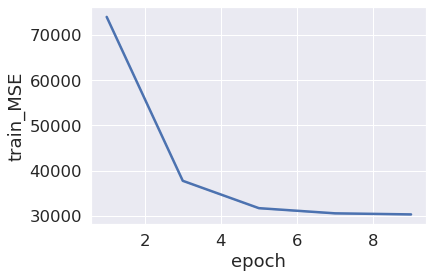

In [26]:
# This needs title: learning curve
sns.lineplot(y='train_MSE', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
                 dashes=False,legend="full",data = regression_df)

### The MSE is going down as expected

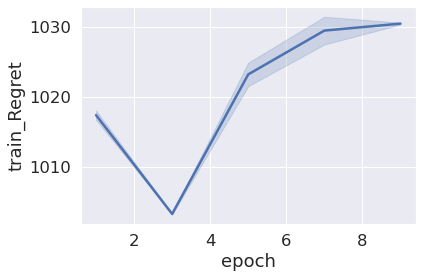

In [27]:


sns.lineplot(y='train_Regret', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
                 dashes=False,legend="full",data = regression_df)

### But regret is going up

## Smart Predict and Optimize Regression Model Model

In [28]:
class SPO:
    def __init__(self, net = nn.Linear(8,1),
                 epochs=8,optim=optim.Adam,batch_size=24,capacity= 100,
                 weights=np.array([1 for i in range(48)]),n_items=48,lr=1,
                 **kwg):
        self.net = net
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = weights
        self.capacity = capacity
        self.n_items = n_items
        self.kwg = kwg
        self.optim = optim
        self.lr = lr

    def get_params(self, deep=True):
        para_dict =  {"net": self.net, "epochs": self.epochs,
        "batch_size":self.batch_size,"weights":self.weights,
        "capacity": self.capacity,"n_items":self.n_items,"optim":self.optim,
        "lr":self.lr}
        # print({**self.kwg})
        # print (dict(para_dict, **self.kwg))
        return para_dict
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def fit(self,X,y):
        self.model = self.net
        self.optimizer = self.optim(self.model.parameters(),lr=self.lr, **self.kwg)
        
        train_df = Dataloader(X,y,self.weights,self.capacity,self.n_items)
        solver_call = problem_solver(self.weights,self.capacity,self.n_items)
        for e in range(self.epochs):
            train_dl = data_utils.DataLoader(train_df, batch_size=self.batch_size,shuffle=True)
            for x_train,y_train,sol_train in train_dl:
                self.optimizer.zero_grad()
                y_pred = self.model(x_train).squeeze()
                
                # START: This part different from MSE-based regression  (add such a style comment)
                y_spo = 2*y_pred - y_train
                grad_list = []
                for i in range(len(y_train)):

                    sol_spo = solver_call.solve_from_torch(y_spo[i])
      
                    # We compute the (sub)gradients directly, see SPO paper
                    grad = sol_spo - sol_train[i]
                    grad_list.append(grad)
                grad = torch.stack(grad_list,0)
                y_pred.retain_grad()
                # gradients do not come from a loss , but we use SPO subgradients   
                y_pred.backward(gradient=grad)
                # This is where this differes from the Two-stage model
                self.optimizer.step()

    def score(self,X,y):
        return score_fucn(self.model,X,y,self.weights,self.capacity,self.n_items)

    def predict(self,X):
        self.model.eval()
        y_pred = self.model(torch.from_numpy(X).float()).squeeze()
        self.model.train()
        return y_pred.detach().numpy()

### Now we will run the SPO model and save the regret and MSE  on test and train data
#### We will be running for multiple epochs to form a leanring curve. So this will take some time.

In [29]:
spo_df = pd.DataFrame()
for epoch in range(1,11,2):
    scoring = {'Regret': make_scorer(regret_score,
            weights = weights,capacity =capacity,n_items= n_items),
                'MSE': make_scorer(mse)}
    model = SPO(optim=optim.SGD, epochs=epoch,lr= 0.01,
            weights = weights,capacity =capacity,
            n_items= n_items)
    cv = repeatrun(len(y_train),len(y_test))
    scores = cross_validate(model, x,y, scoring=scoring,cv=cv, return_train_score=True)
    scores = pd.DataFrame.from_dict(scores)
    scores['epoch'] = epoch
    spo_df = spo_df.append(scores)

In [30]:
spo_df['model'] ="SPO"
rslt_df =  pd.concat([spo_df,regression_df],ignore_index=True)

### Now we compare SPO and two-stage approach

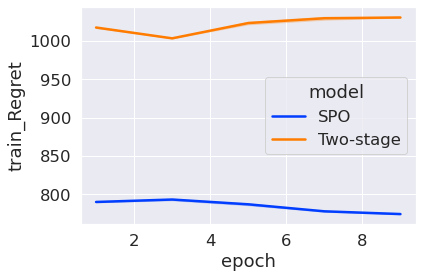

In [31]:
sns.lineplot(y='train_Regret', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
                 dashes=False,legend="full",
                 hue="model",
                palette=sns.color_palette('bright',n_colors=2),
                 data = rslt_df)

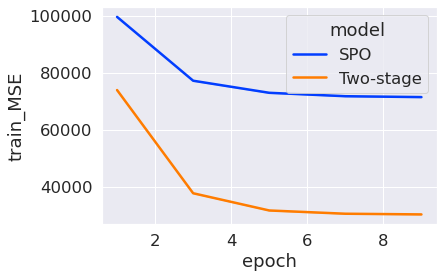

In [32]:
sns.lineplot(y='train_MSE', x='epoch',
#                  markers=['o', 'v', 'D', 'P', 'X', 'h', 'H',  'd', '^', '8','<', '>', '*', 's', 'p',], 
                 dashes=False,legend="full",
                 hue="model",
                palette=sns.color_palette('bright',n_colors=2),
                 data = rslt_df)

### SPO model induces lower regret even though MSE loss is high.

### Now we examine the performance on test data.

In [34]:
rslt_df[rslt_df.epoch==9].groupby(['model']).agg({'test_Regret':['mean','std'],'test_MSE': ['mean','std'],'fit_time':['mean','std']})

test_Regret                test_MSE               fit_time  \
                  mean       std          mean        std        mean   
model                                                                   
SPO         802.398861  1.385137  70441.801823  64.230748  103.615881   
Two-stage  1036.817222  0.181314  32040.900162   2.088218   12.774621   

                     
                std  
model                
SPO        0.559706  
Two-stage  0.641340

## Because we repeatedly call solver while training SPO model, the model fitting time is high for SPO.

## We see, on test data, regret is significantly lower for SPO, confirming the superiority of this approach.